In [15]:
# Make 'artifacts' package importable from this notebook
import sys
from pathlib import Path


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "app.py").exists() or (p / "requirements.txt").exists() or (p / ".git").exists():
            return p
    return start

ROOT = find_repo_root(Path.cwd())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("Repo root:", ROOT)
print("Artifacts directory exists:", (ROOT / "artifacts").exists())


Repo root: c:\Users\PC\JD\__code\python\skripsi
Artifacts directory exists: True


In [16]:
# Resolve artifact path similar to the Streamlit app
from pathlib import Path

def resolve_artifact_path(preferred: str) -> str:
    p = Path(preferred)
    # If absolute and exists, return
    try:
        if p.is_absolute() and p.exists():
            return str(p)
    except Exception:
        pass
    name = p.name
    candidates = [
        ROOT / preferred,  # repo-root relative (e.g., models/NAME.joblib)
        ROOT / "artifacts/notebooks/models" / name,
        ROOT / "artifacts/notebooks" / name,
        ROOT / "models" / name,
        ROOT / "artifacts/models" / name,
        p,  # original as-is
    ]
    for c in candidates:
        try:
            if Path(c).exists():
                return str(c)
        except Exception:
            continue
    return str(p)


In [17]:
# Helpers to normalize yfinance DataFrame for ensure_schema()
import pandas as pd

def normalize_yf(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Flatten MultiIndex columns to first level (e.g., ('Open','') -> 'Open')
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    # Standardize date column naming to 'ds' expected by ensure_schema
    if "Date" in df.columns:
        df = df.rename(columns={"Date": "ds"})
    elif "Datetime" in df.columns:
        df = df.rename(columns={"Datetime": "ds"})
    # If still missing, move datetime index to column
    if "ds" not in df.columns and isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={"index": "ds"})
    return df


### Import Libraries

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import warnings
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')

print("🚀 Starting N-HiTS Model...")
print("="*70)

# Check GPU availability
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using accelerator: {accelerator}")
pl_trainer_kwargs = {
    "accelerator": accelerator,
    "devices": 1,
} if accelerator == "gpu" else {}

emiten = 'BUMI'

🚀 Starting N-HiTS Model...
🔧 Using accelerator: cpu


In [19]:
# Set global seeds for reproducibility

import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use deterministic algorithms where possible (CPU-safe)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass


### Fungsi untuk Rekayasa Fitur

In [20]:
def create_features(df):
    """Menciptakan fitur-fitur teknikal (sesuai dengan hybrid model)"""
    data = df.copy()

    # Price Change (Target untuk N-HiTS)
    data['Price_Change'] = data['Close'].pct_change()
    
    # Previous Close
    data['Prev Close'] = data['Close'].shift(1)

    # Moving Averages
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()

    # RSI
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    gain_avg = gain.rolling(window=14).mean()
    loss_avg = loss.rolling(window=14).mean()
    rs = gain_avg / (loss_avg + 1e-8)
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    data['BB_Upper'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

    # ATR
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift(1))
    low_close = abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1)
    data['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

    # Stochastic
    data['Stochastic_K'] = 100 * (data['Close'] - data['Low'].rolling(window=14).min()) / \
                           (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
    data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

    # CCI
    data['CCI'] = (data['Close'] - data['Close'].rolling(window=20).mean()) / \
                  (0.015 * data['Close'].rolling(window=20).std())

    # OBV
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                           np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0))
    data['OBV'] = data['OBV'].cumsum()

    # Lag features
    for i in range(1, 6):
        data[f'Lag{i}'] = data['Close'].shift(i)

    data = data.dropna().reset_index()
    return data

### LANGKAH 1: Download Data & Rekayasa Fitur

In [21]:
# === CELL: Download data & create features ===
# Set ticker here (single-stock mode) - SAME AS PROPHET
ticker = emiten + '.JK'

print(f"\n{'='*80}")
print(f"📊 STOCK: {ticker}")
print(f"{'='*80}")

print(f"\n📥 Downloading {ticker} data...")
data_raw = yf.download(ticker, period="5y",interval="1d", progress=False)

if isinstance(data_raw.columns, pd.MultiIndex):
    data_raw.columns = data_raw.columns.get_level_values(0)

# Ensure daily frequency and forward-fill missing
data_raw = data_raw.asfreq('D').ffill()
print(f"✅ Data downloaded: {data_raw.shape}")

print(f"🔧 Creating technical indicators...")
data_featured = create_features(data_raw)
print(f"✅ Features created: {data_featured.shape}")


📊 STOCK: BUMI.JK

📥 Downloading BUMI.JK data...
✅ Data downloaded: (1825, 5)
🔧 Creating technical indicators...
✅ Features created: (1776, 27)


In [22]:
# === CELL: Data preparation (features -> TimeSeries, split)
from scipy.signal import savgol_filter

# Prepare dataframe for model
df_prophet = data_featured.rename(columns={'Date': 'ds', 'Close': 'y'})

selected_features = [
    'Prev Close', 'MA20', 'MA50', 'MACD', 'Signal Line',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RSI',
    'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'Stochastic_D', 'CCI', 'OBV', 'Volume'
]

columns_for_model = ['ds', 'y'] + selected_features

df_model_ready = df_prophet[columns_for_model].copy()
df_model_ready['ds'] = pd.to_datetime(df_model_ready['ds'])
# Ensure daily frequency and forward-fill to avoid NaNs introduced by asfreq
df_model_ready = df_model_ready.set_index('ds').asfreq('D').ffill().reset_index()
# Drop any remaining NaNs in target or features
df_model_ready = df_model_ready.dropna(subset=['y'] + selected_features).reset_index(drop=True)

# Split
train_size_full = int(len(df_model_ready) * 0.8)
train_df_pd = df_model_ready.iloc[:train_size_full]
test_df_pd = df_model_ready.iloc[train_size_full:]

print(f"📊 Split: {len(train_df_pd)} train, {len(test_df_pd)} test")
# Optional sanity checks
if train_df_pd.isna().any().any() or test_df_pd.isna().any().any():
    print("⚠️ Warning: NaNs detected after split; consider inspecting df_model_ready.")

📊 Split: 1420 train, 356 test


In [23]:
# === CELL: Scaling and Training ===
# Convert to Darts TimeSeries and scale
train_y = TimeSeries.from_dataframe(train_df_pd, 'ds', 'y', freq='D')
train_cov = TimeSeries.from_dataframe(train_df_pd, 'ds', selected_features, freq='D')

mm_scaler_y = MinMaxScaler(feature_range=(0, 1))
mm_scaler_cov = MinMaxScaler(feature_range=(0, 1))
scaler_y = Scaler(scaler=mm_scaler_y)
scaler_cov = Scaler(scaler=mm_scaler_cov)

train_y_s = scaler_y.fit_transform(train_y)
train_cov_s = scaler_cov.fit_transform(train_cov)

# Training configuration
print("⚡ Training N-HiTS...")
early_stopping = EarlyStopping(monitor="train_loss", patience=10, mode="min")
trainer_kwargs = pl_trainer_kwargs.copy()
trainer_kwargs["callbacks"] = [early_stopping]
trainer_kwargs["enable_progress_bar"] = True
trainer_kwargs["limit_train_batches"] = 0.8
trainer_kwargs["logger"] = False

model = NHiTSModel(
    input_chunk_length=60,
    output_chunk_length=5,  # match app/test horizon (e.g., 5)
    num_stacks=3,
    num_blocks=2,
    num_layers=3,
    layer_widths=192,
    n_epochs=50,
    dropout=0.20,
    batch_size=64,
    random_state=42,
    activation='ReLU',
    MaxPool1d=True,
    pl_trainer_kwargs=trainer_kwargs,
    show_warnings=False,
    save_checkpoints=False,
    force_reset=True
)

model.fit(train_y_s, past_covariates=train_cov_s, verbose=True, max_samples_per_ts=600)
print("✅ Training completed")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.3 M  | train
-------------------------------------------------------------
2.0 M     Trainable params
231 K     Non-trainable params
2.3 M     Total params
9.075     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


⚡ Training N-HiTS...
Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 30.79it/s, train_loss=0.000684]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 30.68it/s, train_loss=0.000684]
✅ Training completed


In [24]:
# === CELL: Prediction ===
# Prepare covariates for the full period and predict
full_cov_pd = df_model_ready
full_cov_ts = TimeSeries.from_dataframe(full_cov_pd, 'ds', selected_features, freq='D')
full_cov_ts_s = scaler_cov.transform(full_cov_ts)

forecast_s = model.predict(n=len(test_df_pd), series=train_y_s, past_covariates=full_cov_ts_s)
forecast_unscaled = scaler_y.inverse_transform(forecast_s)
reconstructed_prices = forecast_unscaled.values().flatten()

original_train_size = len(train_df_pd) + (len(data_featured) - len(df_model_ready))
y_test_actual = data_featured['Close'].iloc[original_train_size:].values
min_len = min(len(y_test_actual), len(reconstructed_prices))
y_test_actual = y_test_actual[:min_len]
reconstructed_prices = reconstructed_prices[:min_len]

# Simpan hasil raw
reconstructed_prices_raw = reconstructed_prices.copy()

print("✅ Prediction completed")

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]
✅ Prediction completed


In [25]:
# === CELL: Evaluation (base metrics) ===
# Align actual vs predicted using the test slice from df_model_ready
# and drop NaNs / non-finite values before computing metrics.

# Ground truth from the prepared model dataframe (matches forecast horizon)
actual_full = df_model_ready['y'].iloc[train_size_full:].to_numpy()
pred_full = reconstructed_prices

# Align lengths
min_len_eval = min(len(actual_full), len(pred_full))
actual = actual_full[:min_len_eval]
pred = pred_full[:min_len_eval]

# Drop NaNs and non-finite values
valid_mask = np.isfinite(actual) & np.isfinite(pred)
actual = actual[valid_mask]
pred = pred[valid_mask]

# Persist back for later cells
y_test_actual = actual
reconstructed_prices = pred

if y_test_actual.size == 0:
    raise ValueError("No valid samples for evaluation after removing NaNs.")

mae = mean_absolute_error(y_test_actual, reconstructed_prices)
mse = mean_squared_error(y_test_actual, reconstructed_prices)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_actual, reconstructed_prices)
# MAPE: avoid divide-by-zero using epsilon
eps = 1e-8
mape = np.mean(np.abs((y_test_actual - reconstructed_prices) / np.where(y_test_actual == 0, eps, y_test_actual))) * 100

# Directional Accuracy (guard when too short)
T = len(y_test_actual) - 1
if T > 0:
    actual_diff = np.diff(y_test_actual)
    pred_diff = np.diff(reconstructed_prices)
    ai = (np.sign(actual_diff) == np.sign(pred_diff)).astype(int)
    da = (1/T) * np.sum(ai) * 100
else:
    da = float('nan')

print(f"\n{'='*80}")
print(f"📊 BASE MODEL RESULTS")
print(f"{'='*80}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"DA    : {da:.2f}%")
print(f"{'='*80}")


📊 BASE MODEL RESULTS
RMSE  : 41.9332
MAE   : 20.7399
R²    : 0.6324
MAPE  : 10.02%
DA    : 26.48%


In [26]:
# === CELL: Final Evaluation (NO POST-PROCESSING to be fair) ===
print(f"\n{'='*80}")
print(f"📊 FINAL N-HiTS RESULTS (Apple-to-Apple with Prophet)")
print(f"{'='*80}")
print(f"Ticker    : {ticker}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"R²        : {r2:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"DA        : {da:.2f}%")
print(f"{'='*80}")

# Additional error statistics
nhits_errors = np.abs(y_test_actual - reconstructed_prices)
print(f"\n   - Average Error: {np.mean(nhits_errors):.2f} IDR")
print(f"   - Max Error: {np.max(nhits_errors):.2f} IDR")
print(f"   - Min Error: {np.min(nhits_errors):.2f} IDR")

print("\n🎉 N-HiTS Model Analysis Completed!")
print("="*80)



📊 FINAL N-HiTS RESULTS (Apple-to-Apple with Prophet)
Ticker    : BUMI.JK
RMSE      : 41.9332
MAE       : 20.7399
R²        : 0.6324
MAPE      : 10.02%
DA        : 26.48%

   - Average Error: 20.74 IDR
   - Max Error: 189.75 IDR
   - Min Error: 0.04 IDR

🎉 N-HiTS Model Analysis Completed!


### LANGKAH 7: Visualisasi


📊 Creating visualizations...
✅ Visualization saved as 'nhits_results.png'


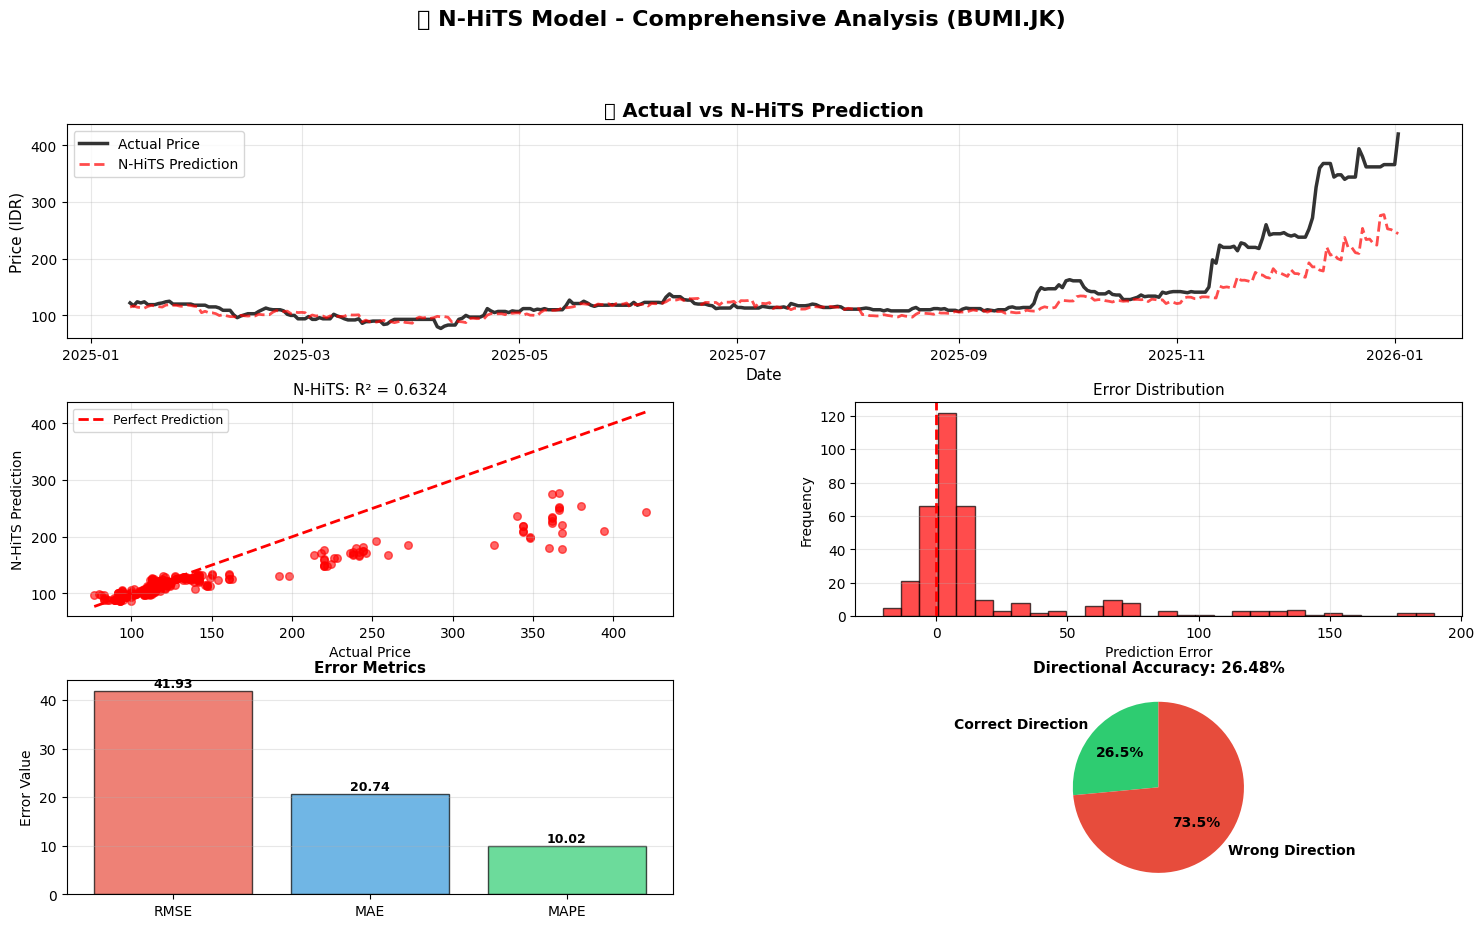

In [27]:
print("\n📊 Creating visualizations...")

# Build test dates aligned to cleaned evaluation arrays (after masking)
# Using df_model_ready ensures consistency with evaluation
all_test_dates = df_model_ready['ds'].iloc[train_size_full:]
# Use the last len(y_test_actual) dates to align with potentially shorter arrays
if len(all_test_dates) >= len(y_test_actual):
    test_dates = all_test_dates.iloc[:len(y_test_actual)].to_numpy()
else:
    # Fallback: truncate to available
    test_dates = all_test_dates.to_numpy()

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Time Series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_dates, y_test_actual, label='Actual Price', color='black', linewidth=2.5, alpha=0.8)
ax1.plot(test_dates, reconstructed_prices, label='N-HiTS Prediction', color='red',
         linestyle='--', linewidth=2, alpha=0.7)
ax1.set_title('📈 Actual vs N-HiTS Prediction', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Price (IDR)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter Plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test_actual, reconstructed_prices, alpha=0.6, color='red', s=30)
ax2.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price', fontsize=10)
ax2.set_ylabel('N-HiTS Prediction', fontsize=10)
ax2.set_title(f'N-HiTS: R² = {r2:.4f}', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = fig.add_subplot(gs[1, 1])
nhits_residuals = y_test_actual - reconstructed_prices
ax3.hist(nhits_residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Prediction Error', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Error Distribution', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Metrics Bar Chart
ax4 = fig.add_subplot(gs[2, 0])
metrics = ['RMSE', 'MAE', 'MAPE']
metric_values = [rmse, mae, mape]
bars = ax4.bar(metrics, metric_values, color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
ax4.set_ylabel('Error Value', fontsize=10)
ax4.set_title('Error Metrics', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Directional Accuracy
ax5 = fig.add_subplot(gs[2, 1])
da_data = [da if np.isfinite(da) else 0, (100-da) if np.isfinite(da) else 100]
colors = ['#2ecc71', '#e74c3c']
labels = ['Correct Direction', 'Wrong Direction']
wedges, texts, autotexts = ax5.pie(da_data, labels=labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title(f'Directional Accuracy: {da:.2f}%', fontsize=11, fontweight='bold')

plt.suptitle(f'📊 N-HiTS Model - Comprehensive Analysis ({ticker})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
# plt.savefig('nhits_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'nhits_results.png'")
plt.show()


In [28]:
# Export N-HiTS artifact to repository 'models' with scalers + features
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

# Prefer the trained variables from above
nhits_model = globals().get('model', None)  # NHiTSModel instance
scaler_y = globals().get('scaler_y', None)  # Darts Scaler for target
scaler_cov = globals().get('scaler_cov', None)  # Darts Scaler for covariates
feature_cols = globals().get('selected_features', None)
ticker_val = globals().get('ticker', None)

if nhits_model is None or not isinstance(nhits_model, NHiTSModel):
    raise RuntimeError("No NHiTSModel instance found (variable `model`). Run training cells first.")
if scaler_y is None or not isinstance(scaler_y, Scaler):
    raise RuntimeError("No fitted Darts Scaler found for target (`scaler_y`). Run training cells first.")
if scaler_cov is None or not isinstance(scaler_cov, Scaler):
    raise RuntimeError("No fitted Darts Scaler found for covariates (`scaler_cov`). Run training cells first.")
if feature_cols is None or len(feature_cols) == 0:
    # Fallback: infer features from a DataFrame that contains ds/y and indicators
    candidate_dfs = [v for v in globals().values() if isinstance(v, pd.DataFrame)]
    known = {'Prev Close','MA20','MA50','MACD','Signal Line','Lag1','Lag2','Lag3','Lag4','Lag5','RSI','BB_Upper','BB_Lower','ATR','Stochastic_K','Stochastic_D','CCI','OBV','High','Low','Volume'}
    for d in candidate_dfs:
        cols = list(d.columns)
        if 'ds' in cols and ('y' in cols or 'Close' in cols):
            feats = [c for c in cols if c not in ['ds','y','Close']]
            if len(set(feats) & known) >= 5:
                feature_cols = feats
                break
if feature_cols is None or len(feature_cols) == 0:
    raise RuntimeError('Could not determine feature_columns; ensure `selected_features` is defined.')

# Derive consistent base name from ticker (preferred) to avoid mismatches
if ticker_val and isinstance(ticker_val, str):
    base_name = ticker_val.split('.')[0].upper()
else:
    # Fallback to any earlier symbol like `emiten`, else generic name
    base_name = str(globals().get('emiten', 'MODEL')).split('.')[0].upper()

# Optional sanity print
print(f"🗂 Export base name: {base_name}")


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / 'app.py').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root(Path.cwd())
export_dir = (repo_root / 'models')
export_dir.mkdir(parents=True, exist_ok=True)

# Save model via Darts native serialization for reliable predict
nhits_path = export_dir / f"{base_name}_nhits.darts"
nhits_model.save(str(nhits_path))  # Darts expects a string path

metrics = {
    'rmse': float(globals().get('rmse')) if 'rmse' in globals() else None,
    'mae': float(globals().get('mae')) if 'mae' in globals() else None,
    'mape': float(globals().get('mape')) if 'mape' in globals() else None,
    'r2': float(globals().get('r2')) if 'r2' in globals() else None,
    'directional_accuracy': float(globals().get('da')) if 'da' in globals() else None,
}

artifact = {
    'model_type': 'nhits',
    'nhits_path': f"models/{base_name}_nhits.darts",
    'scaler_y': scaler_y,
    'scaler_cov': scaler_cov,
    'feature_columns': feature_cols,
    'ticker': ticker_val,
    'metrics': metrics,
}
artifact_path = export_dir / f"{base_name}_nhits.joblib"
joblib.dump(artifact, str(artifact_path))
print('✅ Saved NHITS artifact:', artifact_path.resolve())
print('✅ Saved NHITS model:', nhits_path.resolve())
# Quick confirmation
try:
    print('🔎 Model output_chunk_length:', getattr(nhits_model, 'output_chunk_length', 'N/A'))
except Exception:
    pass


🗂 Export base name: BUMI
✅ Saved NHITS artifact: C:\Users\PC\JD\__code\python\skripsi\models\BUMI_nhits.joblib
✅ Saved NHITS model: C:\Users\PC\JD\__code\python\skripsi\models\BUMI_nhits.darts
🔎 Model output_chunk_length: 5
